In [3]:
from fenics import *
import matplotlib.pyplot as plt
from graphnics import *

plt.rcParams['figure.dpi'] = 500
plt.rcParams['savefig.dpi'] = 500
plt.rcParams.update({'font.size':10})

In [4]:
mu = water_properties['mu']

FF_INNER = 10 # facet function marker for inner boundary
FF_OUTER = 11 # facet function marker for outer boundary
FF_ENDS = 12 # facet function marker for ends of vessel

mesh_names = ['artery', 'artery2', 'vein', 'vein2'] # artery and vein are idealized domains, artery2 and vein2 are from OCT data
centers = [[0,0], [0.584, -0.23], [0,0], [0.707, -0.26]]
inner_radius = 1

In [99]:
# Gather the meshes and normalize their cross-section area

radius_normalized_meshes = []
area_normalized_meshes = []
inner_radius = 1

for i, mesh_name in enumerate(mesh_names):
    
        mesh = Mesh()
        h5 = HDF5File(mesh.mpi_comm(), '../data/' + mesh_name + '.h5', 'r')
        h5.read(mesh, '/mesh', False)
        ff = MeshFunction('size_t', mesh, 1)
        h5.read(ff, '/facet_tags')
        File('ff.pvd')<<ff

        ## Scale mesh so that inner radius is 1

        # Center at (0,0)
        c = mesh.coordinates()
        c -= centers[i]

        # Get coordinates on inner boundary
        V = FunctionSpace(mesh, 'CG', 1)
        d2v = dof_to_vertex_map(V)
        bc = DirichletBC(V, Constant(0), ff, FF_INNER)
        inner_coords = []
        for dof in bc.get_boundary_values():
            vertex = Vertex(mesh, d2v[dof])
            inner_coords.append([vertex.x(i) for i in range(2)])
        min_inner_radius_tilde = np.min(np.linalg.norm(inner_coords, axis=1))

        scaling = inner_radius/min_inner_radius_tilde

        mesh.coordinates()[:,0]*=scaling
        mesh.coordinates()[:,1]*=scaling

        radius_normalized_meshes.append(mesh)
        
        ## Scale mesh so that cross-section area is 1

        area = assemble(Constant(1)*dx(mesh))
        mesh_ = Mesh(mesh) # make a deep copy
        mesh_.coordinates()[:,0]*=area**-0.5*10
        mesh_.coordinates()[:,1]*=area**-0.5*10
        
        print(assemble(Constant(1)*dx(mesh_)))
        area_normalized_meshes.append(mesh_)
    
        #sol, Q, A = solve_for_vp(mesh)
        #R = mu/Q
        #vf = mu/A
        #print(f'R={R:1.2e}, vf={vf:1.2e}, ratio={R/vf:1.2e}')
        #print(f'{Q/A:1.3f}')
        #sol.rename('u-cs', '0')
        #File('u-cs.pvd')<<sol
        #sols.append(sol)


100.00000000000014
100.00000000000017
100.00000000000043
100.0000000000002


In [100]:
# The velocity profile is the solution of a Poisson equation on the cross-section

def solve_for_vp(mesh):
    V = FunctionSpace(mesh, 'CG', 1)
    u = TrialFunction(V)
    v = TestFunction(V)

    a = inner(grad(u), grad(v))*dx
    L = Constant(1)*v*dx

    bc = DirichletBC(V, Constant(0), 'on_boundary')
    vp = Function(V)
    solve(a==L, vp, bc)
    
    return vp

In [131]:
# Compute the resistance parameter on normalized meshes

vps = []

print('Domain & $\mathcal{R}_{R_1=1\\text{mm}^2}$  & $\mathcal{R}_{A=100\\text{mm}^2}$  \\\\ \hline')
for ix, mesh in enumerate(area_normalized_meshes):
    
    vp = solve_for_vp(mesh)
    Q = assemble(vp*dx(mesh))
    Res_A100 = mu/Q
    
    vps.append(vp)
    
    vp = solve_for_vp(radius_normalized_meshes[ix])
    Q = assemble(vp*dx(radius_normalized_meshes[ix]))
    Res_R1 = mu/Q

    print(f'{mesh_names[ix]:<10}  &  {Res_R1:1.2e} & {Res_A100:1.2e} \\\\')

Domain & $\mathcal{R}_{R_1=1\text{mm}^2}$  & $\mathcal{R}_{A=100\text{mm}^2}$  \\ \hline
artery      &  3.65e-03 & 1.18e-05 \\
artery2     &  3.49e-04 & 7.29e-06 \\
vein        &  2.00e-03 & 1.91e-05 \\
vein2       &  3.46e-04 & 1.83e-05 \\


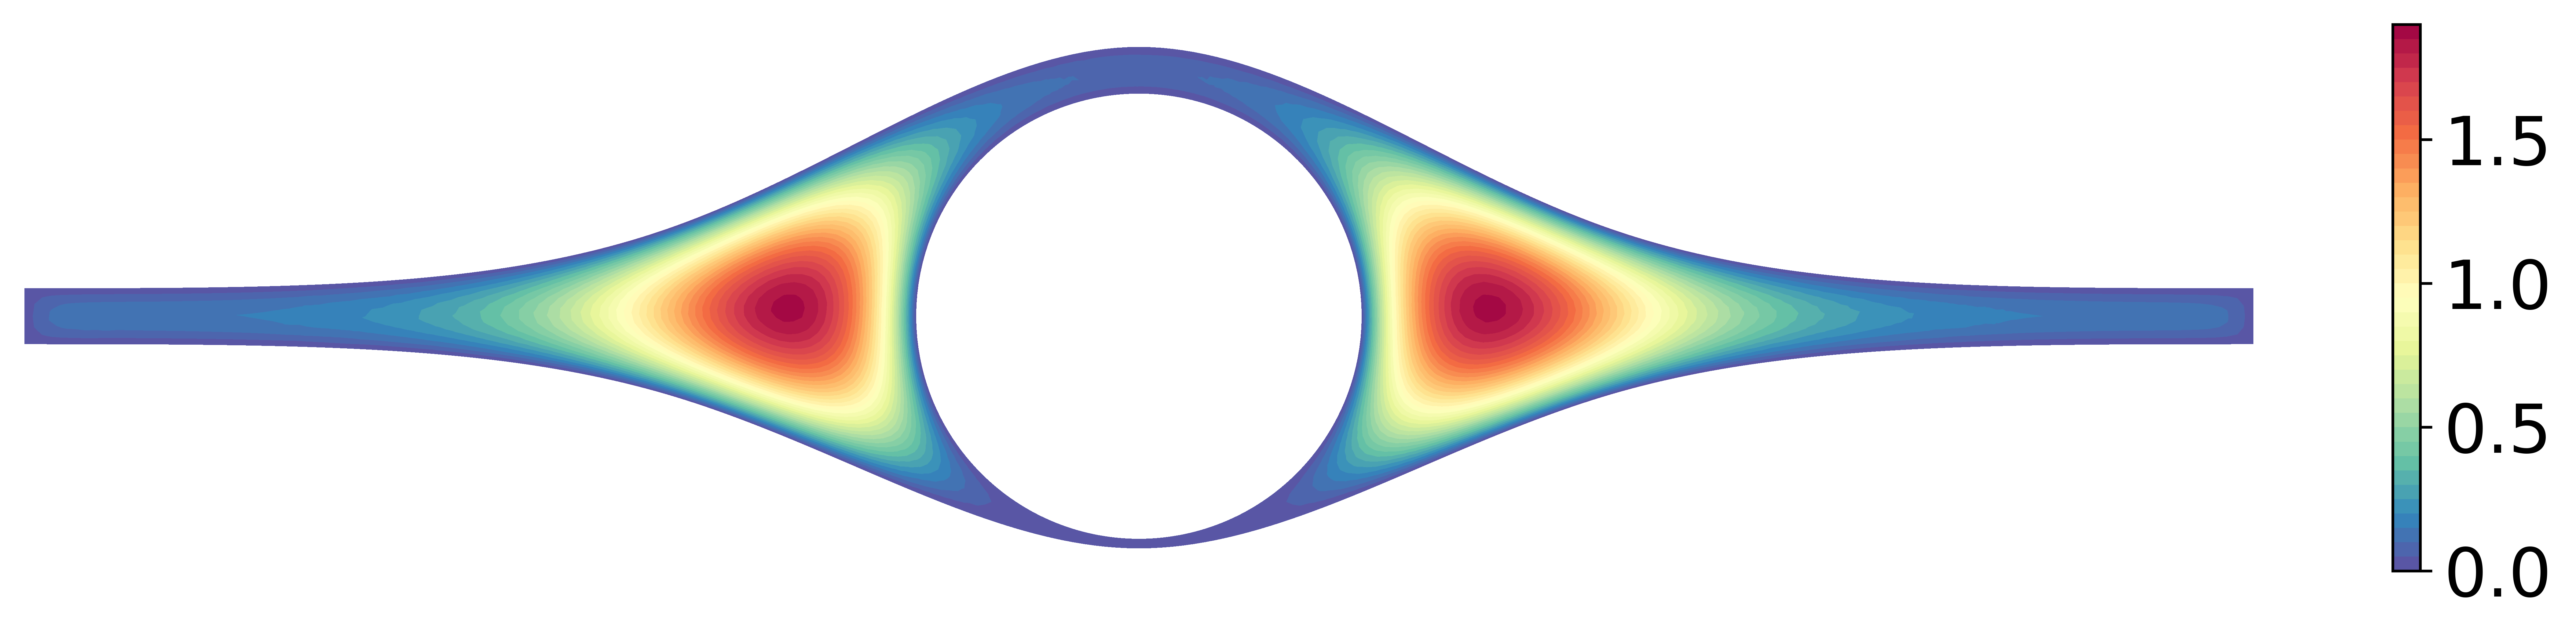

In [117]:
plt.rcParams['figure.dpi'] = 800
plt.rcParams['savefig.dpi'] = 800
plt.rcParams.update({'font.size':20})

plt.figure(figsize=(12,3))

c = plot(vps[0], cmap='Spectral_r', vmin=0)

# adjust minimum and maximum of colorbar
plt.colorbar(c, ticks=[0,0.5, 1,1.5])

plt.axis('off')
plt.autoscale()
plt.tight_layout()
plt.savefig('velocity_profiles/artery.png')
plt.show()

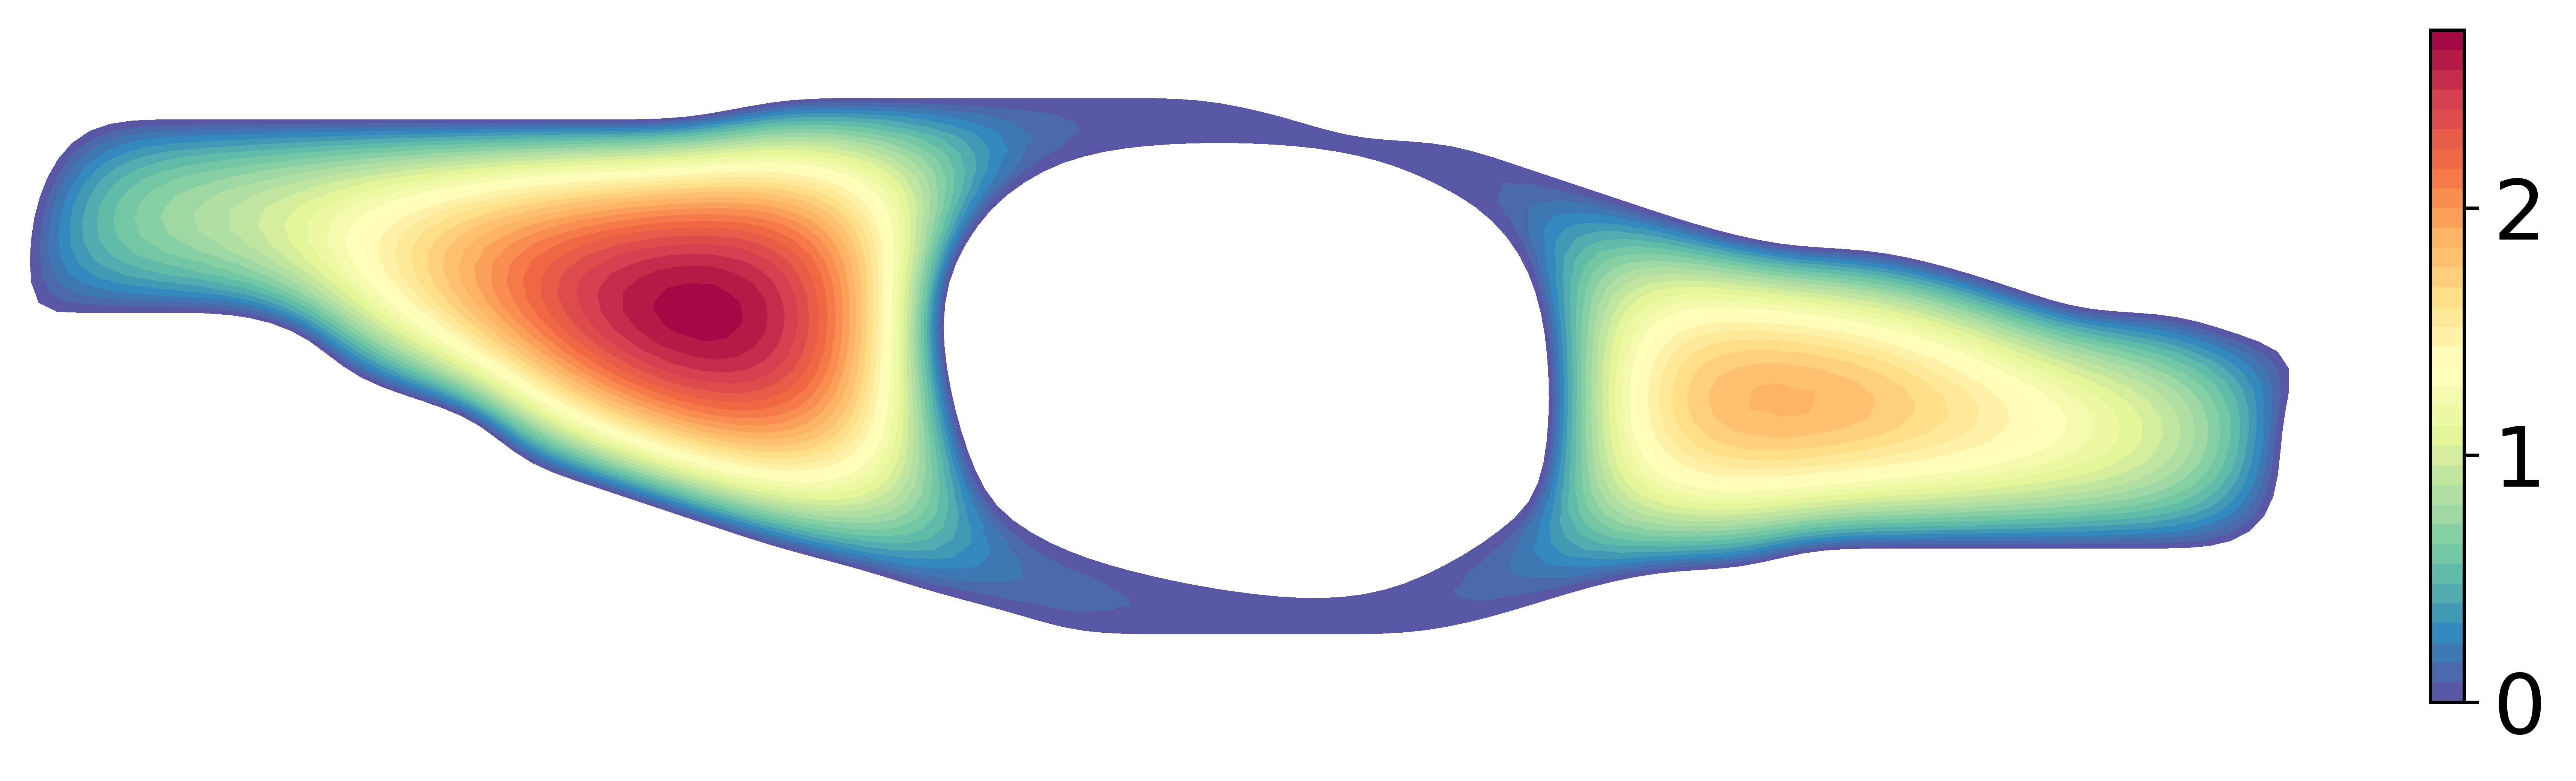

In [118]:
plt.figure(figsize=(10,3))

c = plot(vps[1], cmap='Spectral_r', vmin=0)
plt.colorbar(c, ticks=[0,1,2])
# turn off axis
plt.axis('off')

# make sure the plot is not cropped
plt.axis('off')
plt.autoscale()
plt.tight_layout()
plt.savefig('velocity_profiles/artery2.png')

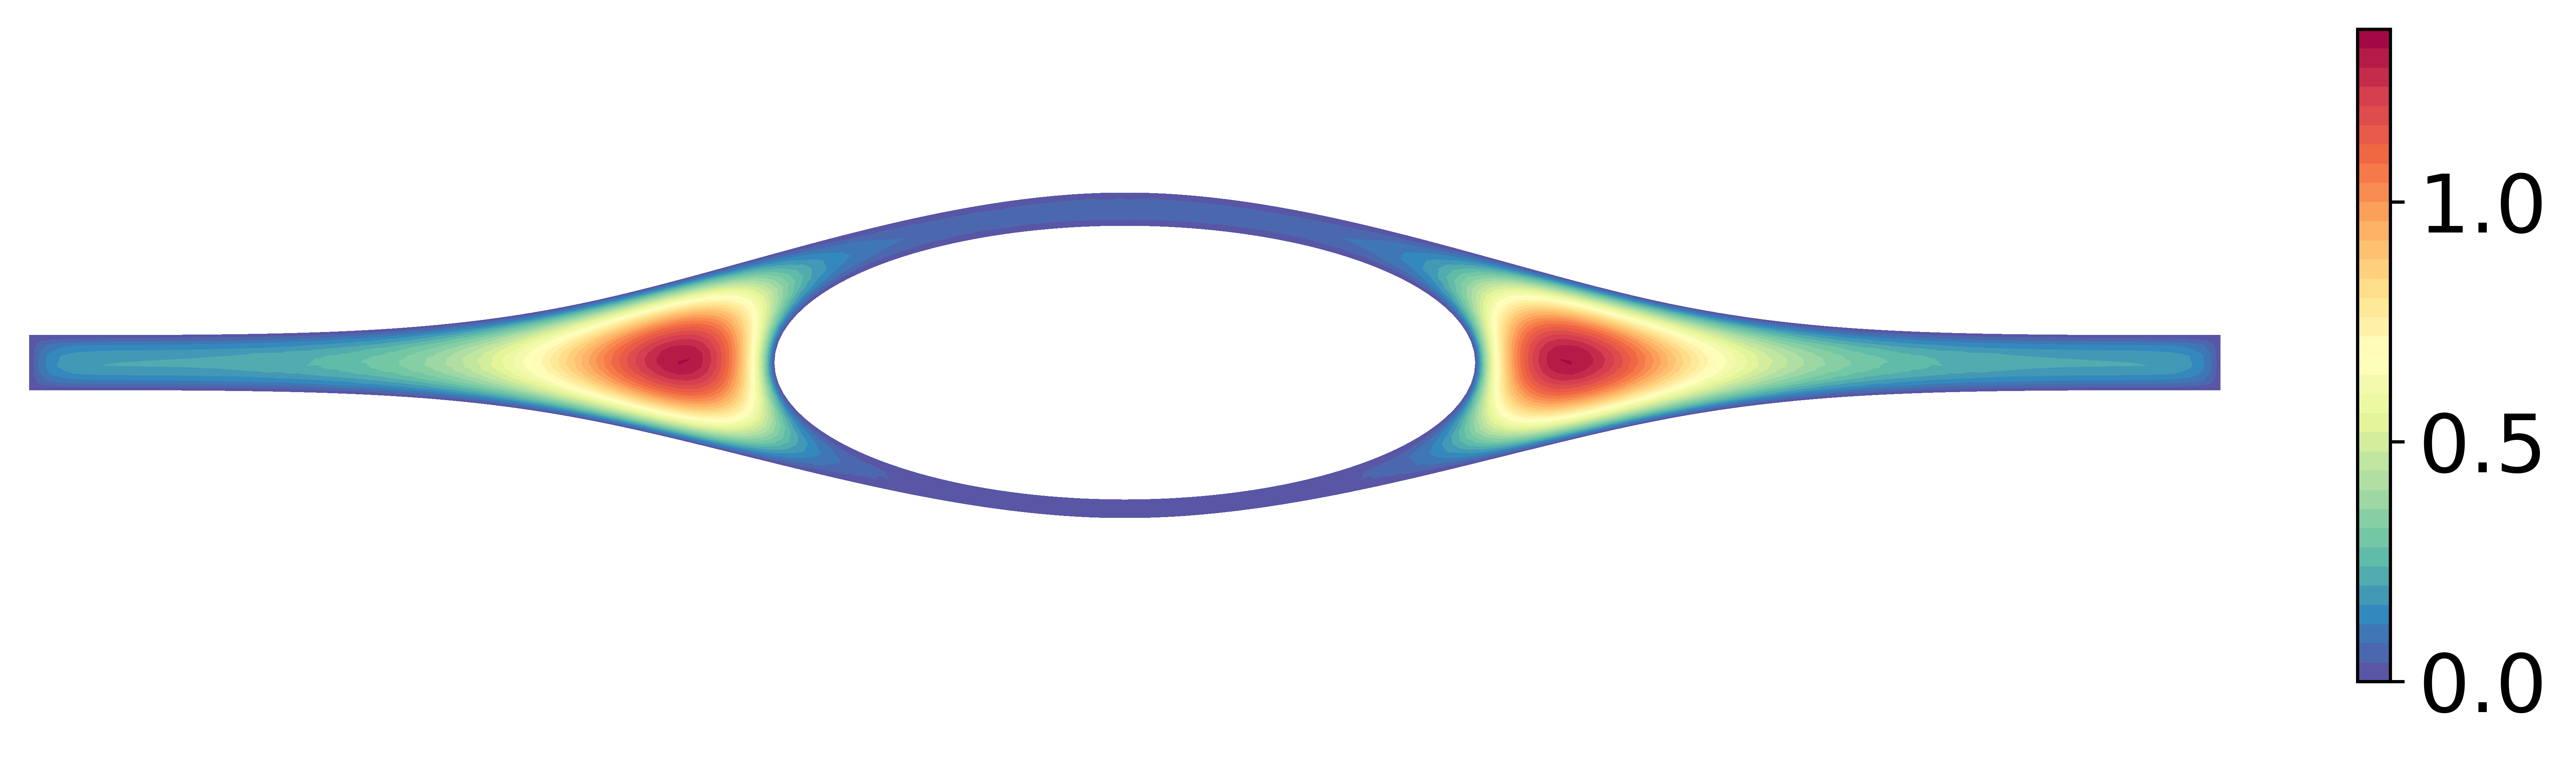

In [119]:
plt.figure(figsize=(10,3))

c = plot(vps[2], cmap='Spectral_r', vmin=0)
plt.colorbar(c, ticks=[0, 0.5, 1])
# turn off axis
plt.axis('off')

# make sure the plot is not cropped
plt.axis('off')
plt.autoscale()
plt.tight_layout()
plt.savefig('velocity_profiles/vein.png')

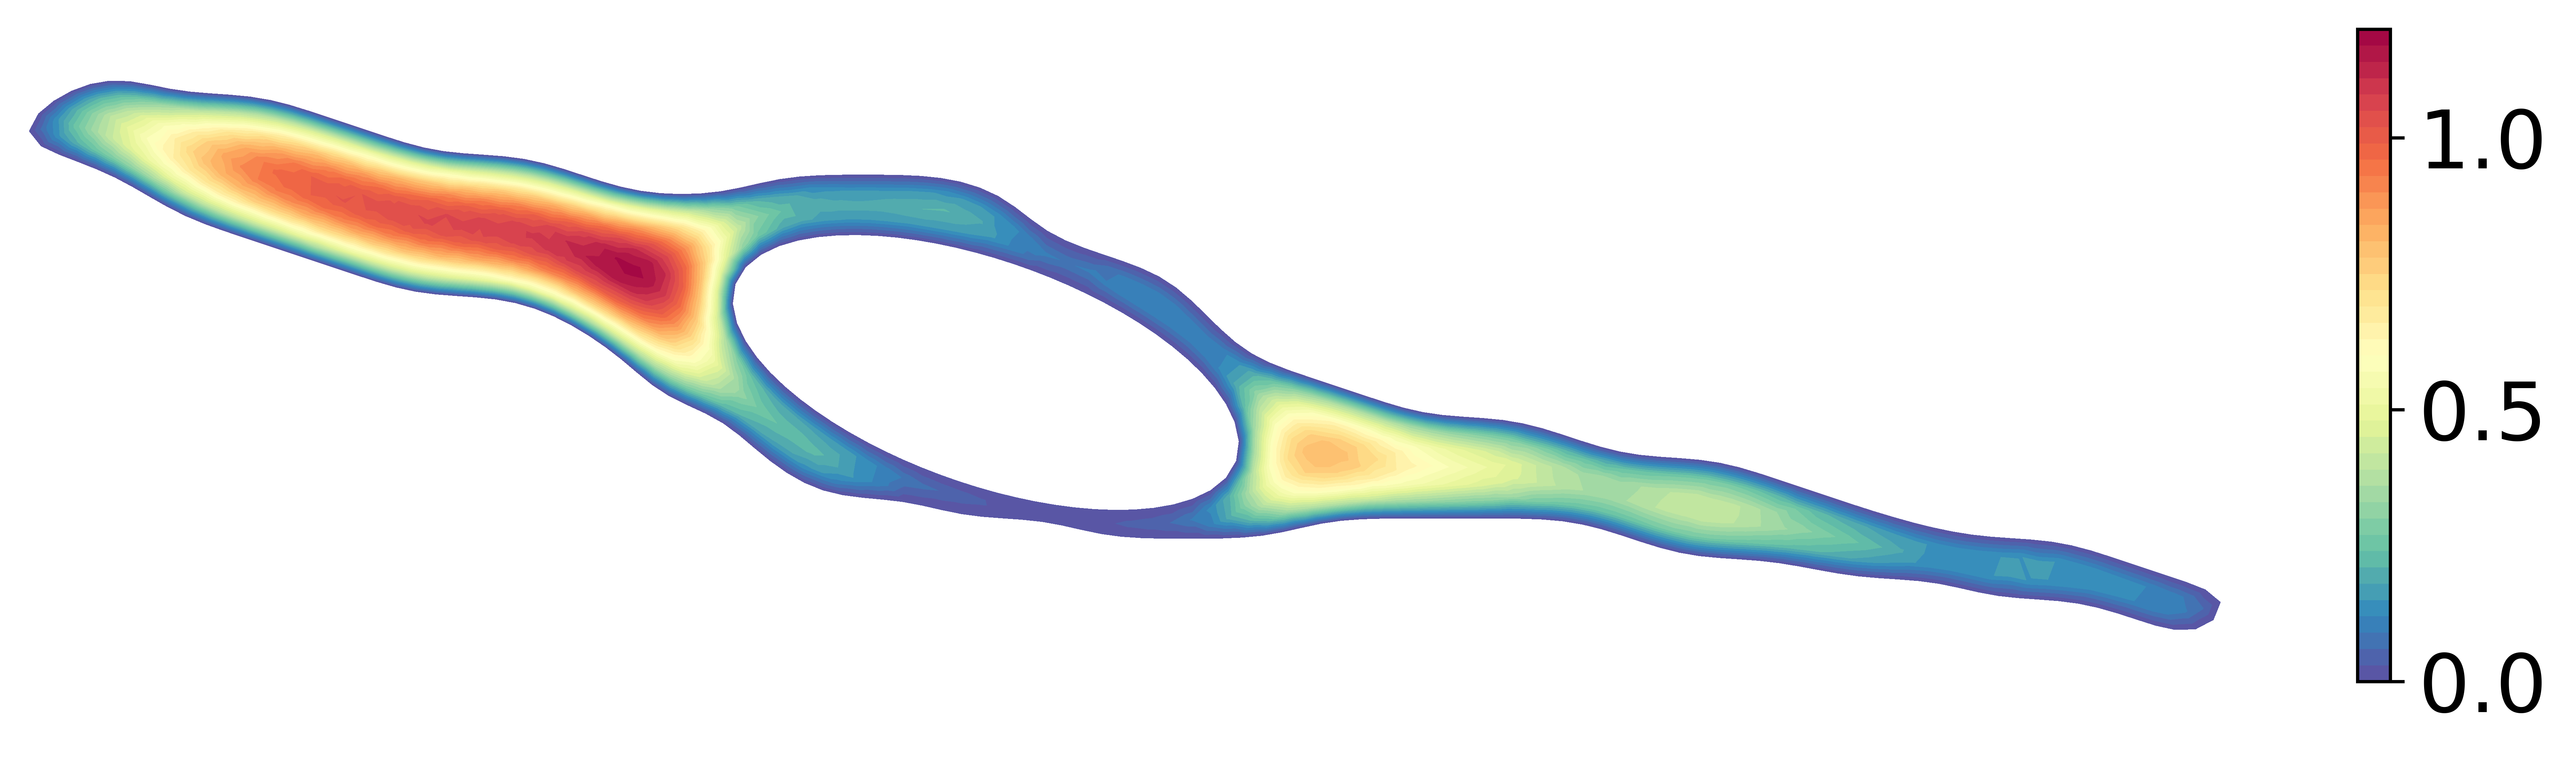

In [120]:
plt.figure(figsize=(10,3))

c = plot(vps[3], cmap='Spectral_r', vmin=0)
plt.colorbar(c, ticks=[0,0.5, 1])
# turn off axis
plt.axis('off')

# make sure the plot is not cropped
plt.axis('off')
plt.autoscale()
plt.tight_layout()
plt.savefig('velocity_profiles/vein2.png')